<a href="https://colab.research.google.com/github/ChaithanyaNadithoka/Face-Emotion-Recognition-using-GoogleNet-ONNX/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install onnxruntime opencv-python-headless pillow numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00


Model Input Shape: ['BatchSize', 3, 224, 224]
Detected Faces: [[ 4  4 39 39]]


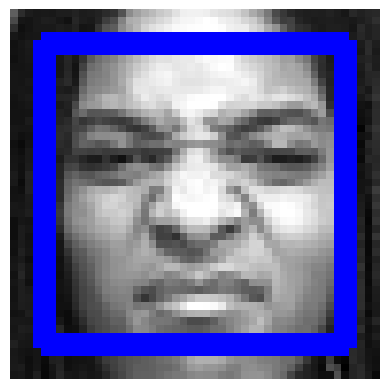

Recognized Emotions: ['Disgust']


In [ ]:
import onnxruntime
import numpy as np
from PIL import Image
from io import BytesIO
import cv2
import matplotlib.pyplot as plt

def recognize_emotion(photo_content):
    # Path to your ONNX model
    onnx_model_path = "model2.onnx"  # Ensure this file is uploaded to the same directory

    # Load the ONNX model
    session = onnxruntime.InferenceSession(onnx_model_path)

    # Get the input shape dynamically
    input_name = session.get_inputs()[0].name
    input_shape = session.get_inputs()[0].shape  # (BatchSize, Channels, Height, Width)
    print("Model Input Shape:", input_shape)

    # Load the input image
    original_image = Image.open(BytesIO(photo_content)).convert("RGB")  # Ensure it's in RGB mode
    input_image = np.array(original_image)

    # Detect faces in the original image
    faces = detect_faces(input_image)

    # Variables to store emotion predictions for each face
    face_emotions = []

    # If faces are detected, proceed with emotion recognition for each face
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            # Draw a rectangle around the detected face
            cv2.rectangle(input_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Crop the detected face region
            face_region = input_image[y:y + h, x:x + w]

            # Resize the face to the expected input shape (Height, Width)
            resized_face = cv2.resize(face_region, (224, 224))

            # Ensure the face region has 3 channels (convert grayscale to RGB if needed)
            if len(resized_face.shape) == 2:  # Grayscale image
                resized_face = cv2.cvtColor(resized_face, cv2.COLOR_GRAY2RGB)
            elif resized_face.shape[2] != 3:  # If not RGB
                resized_face = resized_face[:, :, :3]

            # Convert the resized face to the format (BatchSize, Channels, Height, Width)
            input_array = np.expand_dims(resized_face, axis=0)  # Add BatchSize dimension
            input_array = np.transpose(input_array, (0, 3, 1, 2))  # Change to (N, C, H, W)

            # Perform emotion recognition for the resized face
            result = session.run([], {input_name: input_array.astype(np.float32)})

            # Process and store the emotion prediction for the current face
            face_emotion = process_output(result[0])
            face_emotions.append(face_emotion)

            # Print the emotion label near the rectangle
            cv2.putText(input_image, face_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 66, 247), 2)

        # Return the image with rectangles and emotions
        return input_image, face_emotions

    else:
        print("No faces detected.")
        return input_image, []

def process_output(output_array):
    # Assuming output_array is an array of probabilities for each class
    emotion_labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']
    max_prob_index = np.argmax(output_array)
    recognized_label = emotion_labels[max_prob_index]
    return recognized_label

def detect_faces(image):
    # Load OpenCV's pre-trained Haar Cascade face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert to grayscale for face detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    print("Detected Faces:", faces)
    return faces

# Load the input image (anger.png)
with open("disgust.png", "rb") as img_file:
    photo_content = img_file.read()

# Run the recognition
output_image, emotions = recognize_emotion(photo_content)

# Display the processed image with rectangles and labels
output_image = Image.fromarray(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

# Show the image with emotions
plt.imshow(output_image)
plt.axis("off")
plt.show()

# Print the recognized emotions
print("Recognized Emotions:", emotions)
